# Initial Setup:
This step initializes the necessary configuration.

In [1]:
repo_dir = "Repos"   # Set this to be where your github repos are located.
%load_ext autoreload
%autoreload 2

# Update the load path so python can find modules for the model
import sys
from pathlib import Path
sys.path.insert(0, str(Path.home() / repo_dir / "eye-ai-ml"))
sys.path.insert(0, str(Path.home() / repo_dir / "RETFound_MAE"))

In [3]:
# Prerequisits
import json
import os
import shutil
from PIL import Image

# EyeAI, Deriva, VGG19
from deriva_ml import DatasetSpec, DatasetBag, Workflow, ExecutionConfiguration, VersionPart, DatasetVersion
from deriva_ml import MLVocab as vc
from eye_ai.eye_ai import EyeAI
from models.vgg19 import vgg19_diagnosis_train

# ML Analytics
import torch
import pandas as pd
import numpy as np
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Other Utilities
from pathlib import Path, PurePath
import logging
from datetime import datetime

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', force=True)

In [4]:
from deriva.core.utils.globus_auth_utils import GlobusNativeLogin
catalog_id = "eye-ai" #@param
host = 'www.eye-ai.org'


gnl = GlobusNativeLogin(host=host)
if gnl.is_logged_in([host]):
    print("You are already logged in.")
else:
    gnl.login([host], no_local_server=True, no_browser=True, refresh_tokens=True, update_bdbag_keychain=True)
    print("Login Successful")

2025-06-20 11:09:49,888 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-06-20 11:09:49,889 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>


You are already logged in.


In [5]:
cache_dir = '/data'
working_dir = '/data'
EA = EyeAI(hostname = host, catalog_id = catalog_id, cache_dir= cache_dir, working_dir=working_dir)

2025-06-20 11:09:52,564 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-06-20 11:09:52,565 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>


# Downloading Dataset:
Downloading the datasets. We will work with three datasets: 2-A5T0 (train), 2-A5T2 (val), and 2-A5T4 (test). The dataset order when extracting is always set in the list provided when downloading. Additionally, this code will always download the latest version of the datasets.

In [7]:
datasets = [
        '2-277M',
    ]

to_be_download = []
for dataset in datasets:
    ds_dict = {
        'rid': dataset,
        'materialize':True,
        'version':EA.dataset_version(dataset_rid=dataset),
    }
    to_be_download.append(ds_dict)

workflow_instance = EA.add_workflow(Workflow(
    name="RETFound Model train",
    url="https://github.com/informatics-isi-edu/eye-ai-exec/blob/main/notebooks/RETFound_Huy/RETFOUND_DATA_TEMPLATE.ipynb",
    workflow_type="RETFound Model Train",
))

download_assets = True

config = ExecutionConfiguration(
    # Comment out the following line if you don't need the assets.
    datasets=to_be_download  if download_assets else [],
    assets = ['4-QAGT',  
             ],
    workflow=workflow_instance,
    description="Instance of testing RETFound model")

# Initialize execution
execution = EA.create_execution(config)




source_dataset = "4-YWKJ" # USC test set
crop = True

if crop:
    asset_RID = ["4-MWQ6"]  # VGG19 cropped
else:
    asset_RID = ["4-QAGT"]  # RETFound uncropped

preds_workflow = EA.add_workflow( 
    Workflow(
        name="RETFound Predictions by KB",
        url="https://github.com/informatics-isi-edu/eye-ai-exec/blob/main/notebooks/Sandbox_KB/VGG_Predict.ipynb",
        workflow_type="Test Workflow",
        )
    )

config = ExecutionConfiguration(
    datasets=[ DatasetSpec(rid=source_dataset, version=EA.dataset_version(source_dataset), materialize=True) ],
    assets=asset_RID,
    workflow=preds_workflow,
    description="Instance of creating VGG19 predictions: VGG19 Uncropped on 4-YWKJ USC Test",
    )

execution = EA.create_execution(config)

2025-06-20 11:15:11,072 - INFO - Materialize bag 2-277M... 
2025-06-20 11:15:11,399 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-06-20 11:15:11,399 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>
2025-06-20 11:15:13,366 - INFO - Using cached bag for  2-277M Version:4.5.1
2025-06-20 11:15:13,367 - INFO - Loading /data/2-277M_395876f849b6a2381769d7f9b9667f243d1295f1ae6b8e739c2a46d20110c6e6/Dataset_2-277M
2025-06-20 11:15:14,221 - INFO - Creating new database for dataset: 2-277M in /data/kb_766/EyeAI_working/2-277M@33E-K95Z-QE1T.db
2025-06-20 11:15:14,275 - INFO - Downloading assets ...
2025-06-20 11:16:18,633 - INFO - File [/data/kb_766/EyeAI_working/deriva-ml/execution/4-YX84/downloaded-assets/Execution_Asset/2-277G_uncropped_Mar_11_2025.pth] transfer successful. 3471.44 MB transfer

In [8]:
print(execution)

caching_dir: /data
_working_dir: /data/kb_766/EyeAI_working
execution_rid: 4-YX84
workflow_rid: 4-Q8KR
asset_paths: {'Execution_Asset': [AssetFilePath('/data/kb_766/EyeAI_working/deriva-ml/execution/4-YX84/downloaded-assets/Execution_Asset/2-277G_uncropped_Mar_11_2025.pth')]}
configuration: datasets=[DatasetSpec(rid='2-277M', materialize=True, version=DatasetVersion(major=4, minor=5, patch=1))] assets=['4-QAGT'] workflow='4-Q8KR' parameters={} description='Instance of testing RETFound model' argv=['/home/kb_766/.conda/envs/eye-ai-retfound/lib/python3.10/site-packages/ipykernel_launcher.py', '-f', '/home/kb_766/.local/share/jupyter/runtime/kernel-fc264ea7-d1bc-498f-b427-e2efb050b8f9.json']


# Preprocessing:
Crop the images and move them to the designated folder for training, validation, and testing.          

In [9]:
ds_bag_test = execution.datasets[0]
model_path = str(execution.asset_paths['Execution_Asset'][0])

In [11]:
output_dir = execution._working_dir / execution.execution_rid
output_dir.mkdir(parents=True, exist_ok=True)
output_dir

PosixPath('/data/kb_766/EyeAI_working/4-YX84')

In [13]:
test_image_path_cropped, test_csv_cropped = EA.create_cropped_images(ds_bag = ds_bag_test,
                                                                     output_dir = output_dir / "dataset" / "test",
                                                                     crop_to_eye = False)

In [14]:
test_image_path_cropped

PosixPath('/data/kb_766/EyeAI_working/4-YX84/dataset/test')

In [32]:
!ls /data/kb_766/EyeAI_working/4-YX84/dataset/test/No_Glaucoma

[11:38:59.041941] [11:38:59.041911] [11:38:59.042083] 7P0A.JPG  7X04.JPG  858A.JPG  8B58.JPG	8FXW.JPG  8Q7R.JPG  8ZGP.JPG  96ZT.JPG
7P0C.JPG  7X06.JPG  858J.JPG  8B5E.JPG	8FY2.JPG  8Q7T.JPG  8ZGT.JPG  96ZY.JPG
7P9A.JPG  7XAG.JPG  85DJ.JPG  8B5M.JPG	8G4Y.JPG  8QWC.JPG  902A.JPG  97AW.JPG
7P9J.JPG  7XAM.JPG  85DT.JPG  8B5R.JPG	8G58.JPG  8QWJ.JPG  902M.JPG  97B0.JPG
7PE8.JPG  7XGC.JPG  85QC.JPG  8B6W.JPG	8G7Y.JPG  8R7R.JPG  90MT.JPG  97HC.JPG
7PEA.JPG  7XGM.JPG  85QJ.JPG  8B6Y.JPG	8G84.JPG  8R7T.JPG  90MY.JPG  97HE.JPG
7PXP.JPG  7XN8.JPG  863A.JPG  8BBG.JPG	8GB0.JPG  8RPE.JPG  90SJ.JPG  97PC.JPG
7PXW.JPG  7XNA.JPG  863M.JPG  8BBM.JPG	8GB4.JPG  8RPG.JPG  90SM.JPG  97PE.JPG
7Q1P.JPG  7XYE.JPG  8662.JPG  8BVJ.JPG	8GN4.JPG  8S38.JPG  9120.JPG  97T6.JPG
7Q1T.JPG  7XYG.JPG  8668.JPG  8BVR.JPG	8GN6.JPG  8S3A.JPG  9126.JPG  97T8.JPG
7Q98.JPG  7YCW.JPG  86HT.JPG  8C4A.JPG	8GNE.JPG  8S8T.JPG  917P.JPG  97YG.JPG
7Q9E.JPG  7YD4.JPG  86HW.JPG  8C4J.JPG	8GNM.JPG  8S8W.JPG  917W.JPG  97YP.JPG
7QDC.JPG  

In [28]:
os.makedirs( output_dir / "dataset" / "train" / "No_Glaucoma", exist_ok = True )
os.makedirs( output_dir / "dataset" / "train" / "Suspected_Glaucoma", exist_ok = True )
os.makedirs( output_dir / "dataset" / "val" / "No_Glaucoma", exist_ok = True )
os.makedirs( output_dir / "dataset" / "val" / "Suspected_Glaucoma", exist_ok = True )


In [35]:
import shutil
dummyImg = '/data/kb_766/EyeAI_working/4-YX84/dataset/test/No_Glaucoma/96YM.JPG'
shutil.copy2( dummyImg, '/data/kb_766/EyeAI_working/4-YX84/dataset/train/No_Glaucoma/' )
shutil.copy2( dummyImg, '/data/kb_766/EyeAI_working/4-YX84/dataset/train/Suspected_Glaucoma/' )
shutil.copy2( dummyImg, '/data/kb_766/EyeAI_working/4-YX84/dataset/val/No_Glaucoma/' )
shutil.copy2( dummyImg, '/data/kb_766/EyeAI_working/4-YX84/dataset/val/Suspected_Glaucoma/' )

'/data/kb_766/EyeAI_working/4-YX84/dataset/val/Suspected_Glaucoma/96YM.JPG'

In [15]:
from datetime import datetime
current_date = datetime.now().strftime("%b_%d_%Y") 
print(current_date)

Jun_20_2025


In [16]:
RETFound_output = "./RETFound_output/task"
os.makedirs(RETFound_output, exist_ok= True)

# Training Arguments

<details>
  <summary>Click to expand</summary>

## General Training
- `--batch_size`: Batch size per GPU (default: `128`)
- `--epochs`: Number of training epochs (default: `50`)
- `--accum_iter`: Accumulate gradient iterations (default: `1`)

## Model Parameters
- `--model`: Name of model to train (default: `'RETFound_mae'`)
- `--input_size`: Image input size (default: `256`)
- `--drop_path`: Drop path rate (default: `0.2`)

## Optimizer Parameters
- `--clip_grad`: Clip gradient norm (default: `None`)
- `--weight_decay`: Weight decay (default: `0.05`)
- `--lr`: Learning rate (absolute) (default: `None`)
- `--blr`: Base learning rate (default: `5e-3`)
- `--layer_decay`: Layer-wise learning rate decay (default: `0.65`)
- `--min_lr`: Lower bound for cyclic schedulers (default: `1e-6`)
- `--warmup_epochs`: Number of warmup epochs (default: `10`)

## Augmentation Parameters
- `--color_jitter`: Color jitter factor (default: `None`)
- `--aa`: AutoAugment policy (default: `'rand-m9-mstd0.5-inc1'`)
- `--smoothing`: Label smoothing (default: `0.1`)

## Random Erase Parameters
- `--reprob`: Random erase probability (default: `0.25`)
- `--remode`: Random erase mode (default: `'pixel'`)
- `--recount`: Random erase count (default: `1`)
- `--resplit`: Do not random erase first augmentation split (default: `False`)

## Mixup Parameters
- `--mixup`: Mixup alpha (default: `0`, enabled if > 0)
- `--cutmix`: CutMix alpha (default: `0`, enabled if > 0)
- `--cutmix_minmax`: CutMix min/max ratio (default: `None`)
- `--mixup_prob`: Probability of performing Mixup or CutMix (default: `1.0`)
- `--mixup_switch_prob`: Probability of switching to CutMix (default: `0.5`)
- `--mixup_mode`: Mode of applying Mixup/CutMix (default: `'batch'`)

## Finetuning Parameters
- `--finetune`: Finetune from checkpoint (default: `''`)
- `--task`: Task type for finetuning (default: `''`)
- `--global_pool`: Use global pooling (default: `True`)
- `--cls_token`: Use class token instead of global pool (default: `False`)

## Dataset Parameters
- `--data_path`: Dataset path (default: `'./data/'`)
- `--nb_classes`: Number of classification categories (default: `8`)
- `--output_dir`: Path to save output (default: `'./output_dir'`)
- `--log_dir`: Path for TensorBoard logs (default: `'./output_logs'`)
- `--device`: Device to use for training/testing (default: `'cuda'`)
- `--seed`: Random seed (default: `0`)
- `--resume`: Resume from checkpoint (default: `''`)
- `--start_epoch`: Start epoch number (default: `0`)
- `--eval`: Perform evaluation only (default: `False`)
- `--dist_eval`: Enable distributed evaluation (default: `False`)
- `--num_workers`: Number of DataLoader workers (default: `10`)
- `--pin_mem`: Pin CPU memory in DataLoader for efficient GPU transfer (default: `True`)

## Distributed Training Parameters
- `--world_size`: Number of distributed processes (default: `1`)
- `--local_rank`: Local rank for distributed training (default: `-1`)
- `--dist_on_itp`: Enable distributed training on ITP (default: `False`)
- `--dist_url`: URL for distributed training setup (default: `'env://'`)

## Additional Fine-Tuning Parameters
- `--savemodel`: Save the trained model (default: `True`)
- `--norm`: Normalization method (default: `'IMAGENET'`)
- `--enhance`: Use enhanced data (default: `False`)
- `--datasets_seed`: Dataset random seed (default: `2026`)


# Train and Evaluate:

In [ ]:
from main_finetune import main, get_args_parser 
with execution.execute() as exec:
    args_list = [
        "--model", "RETFound_mae", # If you are using 4-S3KP asset, this would be RETFound_dinov2, which I would recommend take a look into.
        "--savemodel",
        "--global_pool",
        "--batch_size", "16",
        "--world_size", "1",
        "--epochs", "100",
        "--blr", "5e-3", "--layer_decay", "0.65",
        "--weight_decay", "0.05", "--drop_path", "0.2",
        "--nb_classes", "2",
        "--data_path", str(dataset_dir),
        "--input_size", "224",
        "--task", str(RETFound_output),
        "--output_dir", str(RETFound_output),
        "--finetune", str(retfound_pretrained_weight),
    ]

    args = get_args_parser().parse_args(args_list)
    if args.output_dir:
        Path(args.output_dir).mkdir(parents=True, exist_ok=True)

    main(args)

# Evaluate Only:
If you already have a RETFound model, provide its path here to evaluate it directly.

2025-06-20 12:47:11,301 - INFO - Start execution  ...
2025-06-20 12:47:12,901 - INFO - Start execution  ...


[12:47:13.013271] [12:47:13.013267] [12:47:13.013347] [12:47:13.013264] [12:47:13.013364] [12:47:13.013361] [12:47:13.013375] [12:47:13.013249] [12:47:13.013393] [12:47:13.013390] [12:47:13.013404] [12:47:13.013387] [12:47:13.013418] [12:47:13.013415] [12:47:13.013429] Not using distributed mode
[12:47:13.013536] [12:47:13.013534] [12:47:13.013552] [12:47:13.013531] [12:47:13.013566] [12:47:13.013563] [12:47:13.013577] [12:47:13.013528] [12:47:13.013594] [12:47:13.013591] [12:47:13.013605] [12:47:13.013588] [12:47:13.013619] [12:47:13.013616] [12:47:13.013630] [12:47:13.013524] [12:47:13.013650] [12:47:13.013647] [12:47:13.013661] [12:47:13.013644] [12:47:13.013675] [12:47:13.013672] [12:47:13.013686] [12:47:13.013642] [12:47:13.013703] [12:47:13.013700] [12:47:13.013713] [12:47:13.013697] [12:47:13.013727] [12:47:13.013724] [12:47:13.013738] job dir: /home/kb_766/Repos/RETFound_MAE
[12:47:13.013802] [12:47:13.013800] [12:47:13.013815] [12:47:13.013797] [12:47:13.013829] [12:47:13.0138

/home/kb_766/.conda/envs/eye-ai-retfound/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kb_766/.conda/envs/eye-ai-retfound/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/kb_766/.conda/envs/eye-ai-retfound/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/kb_766/.conda/envs/eye-ai-retfound/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
2025-06-20 12:50:00,

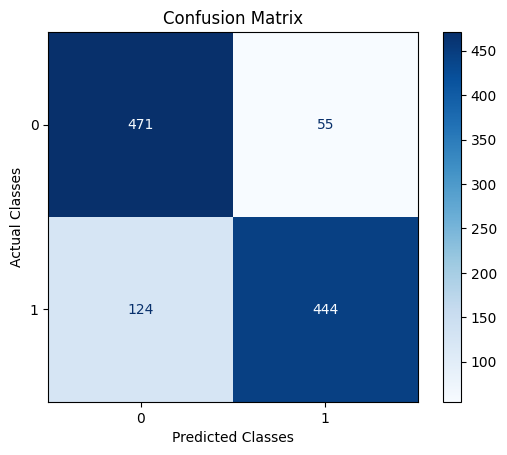

In [38]:
from main_finetune import main, get_args_parser 
with execution.execute() as exec:
    path_to_model = model_path
    args_list = [
        "--model", "RETFound_mae",
        "--eval",
        "--savemodel",
        "--global_pool",
        "--batch_size", "16",
        "--world_size", "1",
        "--epochs", "100",
        "--blr", "5e-3", "--layer_decay", "0.65",
        "--weight_decay", "0.05", "--drop_path", "0.2",
        "--nb_classes", "5",
        "--data_path", '/data/kb_766/EyeAI_working/4-YX84/dataset/',
        "--input_size", "224",
        "--task", str(RETFound_output),
        "--output_dir", str(RETFound_output),
        "--resume", path_to_model,
    ]

    args = get_args_parser().parse_args(args_list)
    if args.output_dir:
        Path(args.output_dir).mkdir(parents=True, exist_ok=True)

    main(args)

In [40]:
RETFound_output

'./RETFound_output/task'

In [49]:
#pd.read_csv('./RETFound_output/task/RETFound_output/task/metrics_test.csv')
pd.read_csv('./RETFound_output/task/RETFound_output/task/roc_predictions_test.csv')  

,Filename,True Label,Prediction,Probability Score
0,7P0A.JPG,0,0,0.011826
1,7P0C.JPG,0,0,0.016630
2,7P9A.JPG,0,0,0.006584
3,7P9J.JPG,0,0,0.020970
4,7PE8.JPG,0,0,0.007980
...,...,...,...,...
1089,AH5P.JPG,1,1,0.956500
1090,AH6P.JPG,1,1,0.919000
1091,AH6R.JPG,1,1,0.618700
1092,AHCR.JPG,1,1,0.927000


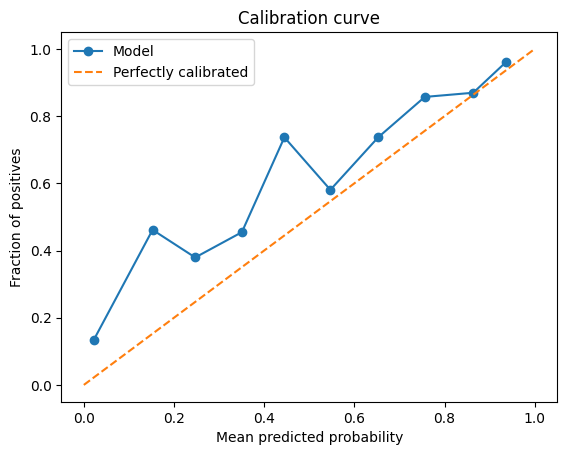

In [54]:
# Calibration curve
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

preds = pd.read_csv('./RETFound_output/task/RETFound_output/task/roc_predictions_test.csv') 
prob_true, prob_pred = calibration_curve( preds["True Label"], preds["Probability Score"], n_bins=10, strategy='uniform')
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.show()

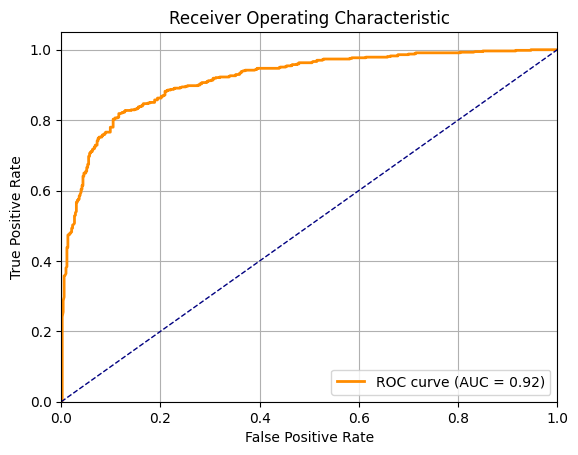

In [58]:
from sklearn.metrics import roc_curve, auc

y_true = preds["True Label"]
y_scores = preds["Probability Score"]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Upload results:
We now need to set up the paths to upload the files to the catalog. Please note that this process uploads a copy of the files, even when clean_folder=True. The original files will remain on your system in case you wish to revisit them later. However, you should consider deleting them afterward to conserve storage.

Alternatively, you can move the files directly to the corresponding path created by execution.asset_file_path(). This ensures that you are uploading the original files instead of creating a copy.

In [ ]:
#This loop creates copies.
for filename in os.listdir(RETFound_output):
    file_path = os.path.join(RETFound_output, filename)
    if os.path.isfile(file_path):
        asset_type = ""
        if filename.endswith(('csv', 'jpg', 'txt')):
            asset_type = "Model_Prediction"
        elif filename.endswith('pth'):
            asset_type = "Diagnosis_Model"
        if asset_type != "":
            path = execution.asset_file_path(
                asset_name="Execution_Asset",
                file_name=file_path,
                asset_types=asset_type
            )

In [ ]:
#Upload and end the execution
execution.upload_execution_outputs(clean_folder=True)